## Imports

In [2]:
import torch
import shutil
import random
import glob

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

from torch import optim
from torch import nn

from matplotlib.patches import Rectangle

import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision import models

#import torchvision.models as models
#from torchvision.transforms import Compose
#from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Data sorting

In [4]:
f1  = open("class_string.txt", "r").read().split("\n")
f2  = open("fname_string.txt", "r").read().split("\n")
f3 = open("bbox.txt", "r").read().split("\n")
totbbox = []
for ind, line in enumerate(f3):
    f1[ind] = int(f1[ind])
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = float(bbox[0])
    bbox[1] = float(bbox[1])
    bbox[2] = float(bbox[2])
    bbox[3] = float(bbox[3])
    totbbox.append(bbox)
fin_list = []
for i in range(len(f2)):
    fin_list.append([f2[i],f1[i],totbbox[i][0],totbbox[i][1],totbbox[i][2],totbbox[i][3]])
df = pd.DataFrame(fin_list, columns=['image_id','labels', 'x0','y0','x1','y1'])


['00001.jpg', 14, 39.0, 116.0, 569.0, 375.0]
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196}


## Data Handler


In [5]:
class CarDataset(Dataset):
    def __init__(self, df, image_dir, transforms= None):
        super().__init__()
        
        self.df = df
        self.image_ids = self.df['image_id']
        self.image_dir = image_dir
        self.labels = self.df['labels']
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image_id"]==image_id]
        
        img = Image.open(self.image_dir/image_id)
        img = transforms.ToTensor()(img)
        
        boxes = records[["x0","y0", "x1", "y1"]].values
        boxes = torch.tensor(boxes)
        boxes = boxes.type(torch.FloatTensor)
        labels = records["labels"].values
        labels = torch.tensor(labels)
        labels = labels.type(torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return img, target
                            
                                  
                                  
    def __len__(self):
        return self.image_ids.shape[0]
    
def collate_fn(batch):
    return tuple(zip(*batch))  
        
dataset = CarDataset(df, Path.cwd() / "cars_train", f1) #"train_all"
        
datloaded = DataLoader(dataset, batch_size=2, collate_fn = collate_fn)        

## Create model

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True, pretrained_backbone = True)#, num_classes = 197)

classes = 197
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

load_old_model = False

if(load_old_model):
    model.load_state_dict(torch.load(Path.cwd() / "one_epoch"))



FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

## Training


In [5]:
model.train()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 12
for epoch in range(num_epochs):
    for i,(b_x, b_y) in enumerate(datloaded):
        b_x = [item.to(device) for item in b_x]
        b_y = [{key: values.to(device) for key, values in target.items()} for target in b_y]
        loss_dict=model(b_x,b_y)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if(i%100 == 0):
            print(losses)
    lr_scheduler.step()
    print(epoch)

if(save_model):
    torch.save(model.state_dict(), "Model_1")
    

tensor(5.0157, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2543, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2559, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3233, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2847, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3624, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2878, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2569, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2294, device='cuda:0', grad_fn=<AddBack

tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(0.1444, device='cuda:0', grad_fn=<AddBa

tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0899, device='cuda:0', grad_fn=<AddBack

tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1524, device='cuda:0', grad_fn=<AddB

## Evaluation

[{'boxes': tensor([[ 74.3598, 107.9366, 460.0898, 325.7195],
        [ 34.3852, 109.8438, 448.2893, 330.0079],
        [  7.7427, 114.0272, 446.5669, 321.2332],
        [ 18.6642, 112.1549, 445.6015, 320.4507],
        [ 37.6471, 110.6056, 457.5036, 323.2652],
        [ 18.5607, 106.8645, 428.0597, 324.8833],
        [ 15.8598, 114.9316, 447.2659, 319.9559],
        [ 32.5894, 115.1117, 459.2027, 329.7445],
        [ 13.2560, 115.8879, 473.8143, 321.3981],
        [ 11.7969, 100.7688, 429.1763, 325.6155],
        [ 34.7264, 106.7374, 430.5243, 334.1995],
        [ 29.8243,  92.8188, 419.9144, 336.2351],
        [ 27.6150, 118.3760, 435.0172, 323.2191],
        [ 34.0476, 121.6978, 437.6028, 320.8215],
        [ 32.1506, 107.9511, 455.7647, 330.4863],
        [ 33.4620,  96.7374, 455.6729, 330.6461]], device='cuda:0'), 'labels': tensor([129,   4,  66,  98, 128,  44, 192,   3,   2, 188,  67,   7,  61,   5,
        187, 162], device='cuda:0'), 'scores': tensor([0.1078, 0.0887, 0.0843, 0.0

Text(tensor(74.3598, device='cuda:0'), tensor(107.9366, device='cuda:0'), 'Label: 129, score: 0.10776926577091217')

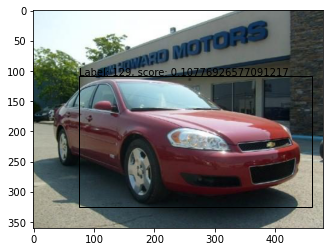

In [22]:
def eval_and_plot_image(model, df, indx):
    model = model.eval()
    image, target = df[indx]
    images = torch.stack([image]+[image]).to(device)
    with torch.no_grad():
        out=model(images)
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1, 2, 0))
    boxes=[]
    height=[]
    width=[]
    box = out[0]['boxes'][0]
    width=(box[2]-box[0])
    height=(box[3]-box[1])
    ax.add_patch(Rectangle((box[0],box[1]),width,height,fill = False))
    keep = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], 0.3)
    for indx in keep:
        s = "Label: {}, score: {}".format(out[0]['labels'][indx],out[0]['scores'][indx])
        ax.text(out[0]['boxes'][indx][0],out[0]['boxes'][indx][1],s)

        
eval_and_plot_image(model, dataset, 6)
